In [2]:
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, CategoryEncoding, Input, Rescaling
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy
from tensorflow.keras.models import load_model
import keras
from keras import backend as K
import os
import cv2
import imghdr
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd

In [3]:
# OPTIONAL: limit NVRAM Usage on GPUs
gpus = tf.config.experimental.list_physical_devices('GPU')

for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)


In [4]:
# Initialise directories
data_dir = '230517_Consolidated Data'
image_exts = ['jpeg', 'jpg']

image_size = (480, 640)
batch_size = 32 

In [1]:
# Remove corrupt images

for image_class in os.listdir(data_dir):
    
    try:

        for image in os.listdir(os.path.join(data_dir, image_class)):
            
            image_path = os.path.join(data_dir, image_class, image)

            try:
                img = cv2.imread(image_path)
                tip = imghdr.what(image_path)

                if tip not in image_exts:
                    print(f'Image not in ext list {image_path}')
                    os.remove(image_path)

            except Exception as e:
                print(f'Issue with image {image_path}')
                os.remove(image_path)

    except NotADirectoryError:              
        pass

NameError: name 'os' is not defined

In [5]:
# Load data
data = tf.keras.utils.image_dataset_from_directory(data_dir, image_size=(480, 640), label_mode='categorical')
classes = len(data.class_names)

Found 82963 files belonging to 2 classes.
Metal device set to: Apple M1 Max

systemMemory: 32.00 GB
maxCacheSize: 10.67 GB



In [6]:
# Inspect data

# Convert data into numpy iterator
data_iterator = data.as_numpy_iterator()

# Convert into batch
batch = data_iterator.next()

# Image 0 represented as numpy array
batch[0].shape

2023-05-18 18:05:06.780727: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


(32, 480, 640, 3)

In [ ]:
y = []
for batch in data.as_numpy_iterator():
    
    y += [batch[1]]


display(y)

In [ ]:
# Get another batch from iterator
batch = data_iterator.next()

n = 10

# Check integer assigned to class
fig, ax = plt.subplots(ncols=n, figsize=(20,20))

for idx, img in enumerate(batch[0][:n]):
    ax[idx].imshow(img.astype(int))
    l = "particle drag"
    if batch[1][idx][1] == 1:
        l = "ok"
    ax[idx].title.set_text(l)


In [7]:
# Split data
train_size = int(len(data) * 0.7)
test_size = int(len(data) * 0.1)
val_size = int(len(data) * 0.2) 

In [8]:
# Allocate training/validating/testing sizes
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size + val_size).take(test_size)

In [8]:
# Model architecture
model = Sequential()

model.add(Rescaling(1./255, input_shape=(image_size[0], image_size[1], 3)))

model.add(Conv2D(32, (3,3), 1, activation='relu',input_shape=(image_size[0], image_size[1], 3)))
model.add(MaxPooling2D())

model.add(Conv2D(64, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())

model.add(Conv2D(64, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())

model.add(Conv2D(64, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())

model.add(Flatten())

model.add(Dense(256, activation='relu'))
model.add(Dense(classes))           # no activation due logits=True

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 480, 640, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 478, 638, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 239, 319, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 237, 317, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 118, 158, 64)     0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 116, 156, 64)      3

In [9]:
# Compute class weights and custom loss function
total_count = len(os.listdir(data_dir))
ok_count = len(os.listdir(os.path.join(data_dir, 'ok')))
defect_count = len(os.listdir(os.path.join(data_dir, 'defect')))

weights = tf.constant([total_count/ok_count, total_count/defect_count])

# Define custom loss function
def weighted_cross_entropy(y_true, y_pred):
 
    ce = tf.nn.softmax_cross_entropy_with_logits(labels=y_true, logits=y_pred)
    y_true_class = tf.argmax(y_true, axis=1)
    weights_ce = tf.gather(weights, y_true_class)
    weighted_ce = ce * weights_ce
    
    return tf.reduce_mean(weighted_ce)

In [10]:
# learning rate scheduler

def scheduler(epoch, lr):
    if epoch < 5:
        return lr

    else:
        return lr * tf.math.exp(-0.1)
    

lr_schedule = tf.keras.callbacks.LearningRateScheduler(scheduler)

In [11]:
# Compile model
model.compile(optimizer='adam', loss=weighted_cross_entropy, metrics=['accuracy'])

In [12]:
# Train the model
logdir = 'logs'

# Callback to save tensorboard log to logdir
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

# Training using model.fit
# hist = model.fit(train, epochs=10, validation_data=val, callbacks=[tensorboard_callback])
hist = model.fit(train, epochs=15, validation_data=val, callbacks=[tensorboard_callback, lr_schedule])

Epoch 1/15
1815/1815 [==============================] - 469s 258ms/step - loss: 1.0782e-05 - accuracy: 0.9583 - val_loss: 9.0879e-06 - val_accuracy: 0.9600 - lr: 0.0010
Epoch 2/15
1815/1815 [==============================] - 462s 255ms/step - loss: 7.3461e-06 - accuracy: 0.9657 - val_loss: 2.3387e-06 - val_accuracy: 0.9893 - lr: 0.0010
Epoch 3/15
1815/1815 [==============================] - 470s 259ms/step - loss: 2.1969e-06 - accuracy: 0.9903 - val_loss: 2.0569e-06 - val_accuracy: 0.9913 - lr: 0.0010
Epoch 4/15
1815/1815 [==============================] - 466s 257ms/step - loss: 1.3910e-06 - accuracy: 0.9934 - val_loss: 1.8819e-06 - val_accuracy: 0.9930 - lr: 0.0010
Epoch 5/15
1815/1815 [==============================] - 467s 257ms/step - loss: 8.8280e-07 - accuracy: 0.9954 - val_loss: 1.8506e-06 - val_accuracy: 0.9955 - lr: 0.0010
Epoch 6/15
1815/1815 [==============================] - 466s 257ms/step - loss: 8.5272e-07 - accuracy: 0.9961 - val_loss: 2.0435e-06 - val_accuracy: 0.9957

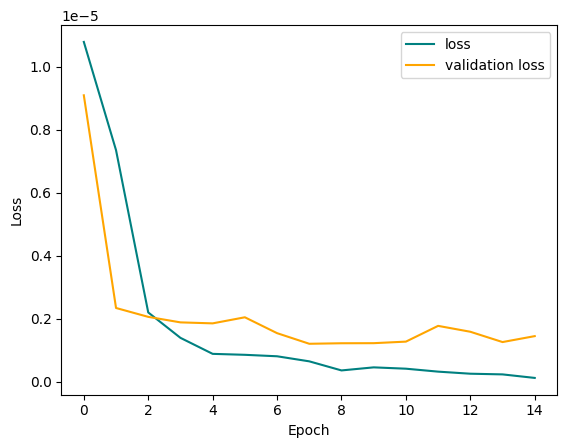

In [13]:
# Plot performance
# hist.history

fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.show()

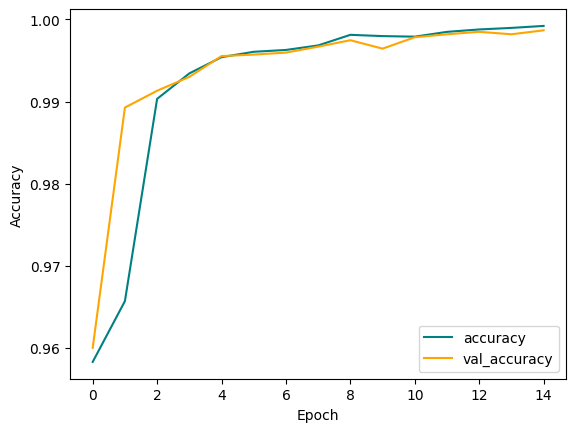

In [14]:
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()

In [15]:
# Evaluate model performance
precision = Precision()
recall = Recall()
bin_acc = BinaryAccuracy()

In [ ]:
figs = 0
for batch in test.as_numpy_iterator():
    figs += 1
    # Check integer assigned to class

    X, y = batch

    yhat = model.predict(X)

    n = 10
    fig, ax = plt.subplots(ncols=n, figsize=(20,20))


    for idx, img in enumerate(batch[0][:n]):
        ax[idx].imshow(img.astype(int))
        pred = np.around(np.array(yhat[idx]),2)
        l = "particle drag"
        if batch[1][idx][1] > 0:
            l = "ok"
        ax[idx].title.set_text(l)

    if figs > 5:
        break
    
    

    

In [16]:
for batch in test.as_numpy_iterator():
    X, y = batch
    yhat = model.predict(X)
    
    precision.update_state(y, yhat)
    recall.update_state(y, yhat)
    bin_acc.update_state(y, yhat)

print(f'(Precision = {precision.result()}\nRecall = {recall.result()}\nCategorical Accuracy = {bin_acc.result()})')

1/1 [==============================] - 0s 36ms/step
(Precision = 0.998912513256073
Recall = 0.9974662065505981
Categorical Accuracy = 0.99819016456604)


In [18]:
# Save the model
model.save(os.path.join('models', 'dense3_softmax', 'particledrag_dataset=230517_epochs=15_WeightedCategoricalCrossentropy_LRS=True.h5'))     # enter name of model